<!--BOOK_INFORMATION-->
<img style="float: right; width: 100px" src="https://raw.github.com/pyomeca/design/master/logo/logo_cropped.svg?sanitize=true">

<font size="+2">Pyosim in the cloud</font>

<font size="+1">with [pyomeca](https://github.com/pyomeca/pyom</font>a)

Romain Martinez (martinez.staps@gmail.com | [GitHub](https://github.com/romainmartinez))


<!--NAVIGATION-->
< [Analyses](02.00-men-women.ipynb) | [Contents](Index.ipynb) | [Joint reactions](02.02-joint-reactions.ipynb) >

# Muscle activations & muscles forces

In [1]:
from pathlib import Path

import yaml
import numpy as np
import pandas as pd
import altair as alt
from pyosim import Conf
from pyomeca import Analogs3d
import spm1d
import matplotlib.pyplot as plt

from src.util import (
    parse_conditions,
    condition_counter,
    random_balanced_design,
    get_spm_cluster,
    ridge_plot,
    describe_clusters,
)

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black
alt.data_transformers.enable("json")
# to make this notebook's output stable across runs
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [3]:
aws_conf = yaml.safe_load(open("../conf.yml"))

conf = Conf(project_path=aws_conf["path"]["project"]["local"])
conf.check_confs()

Project loaded
Configuration file loaded


## Reading files

In [4]:
suffix = "_StaticOptimization_activation"
# suffix = "_StaticOptimization_force"

act = (
    pd.concat(
        [
            Analogs3d.from_sto(ifile)
            .time_normalization()
            .to_dataframe()
            .assign(filename=ifile.stem)
            for ifile in conf.project_path.glob(f"*/3_static_optimization/*{suffix}*")
        ]
    )
    .pipe(parse_conditions, suffix="wu_", prefix=suffix)
    .reset_index()
    .assign(index=lambda x: x["index"] / 100)
    .query("mass != 18 & height == 2")
)

act.head()

,index,LVS,TRP1,TRP2,TRP3,TRP4,RMN,RMJ1,RMJ2,SRA1,...,AC3,GH1,GH2,GH3,filename,participant,men,height,mass,n_trial
0,0.00,0.010001,0.010003,0.010001,0.010000,0.010000,0.010000,0.010000,0.010001,0.918577,...,0.197347,-0.009783,0.018975,-0.013833,CamBF6H2_2,camb,0,2,6,2
1,0.01,0.010008,0.010023,0.010005,0.010002,0.010000,0.010002,0.010003,0.010004,0.981332,...,0.012865,-0.014570,0.022495,-0.004664,CamBF6H2_2,camb,0,2,6,2
2,0.02,0.054300,0.426400,0.012475,0.010014,0.010001,0.010070,0.010018,0.010021,0.433334,...,0.017376,-0.020438,0.025611,0.008201,CamBF6H2_2,camb,0,2,6,2
3,0.03,0.121485,0.400511,0.294346,0.110924,0.010019,0.017028,0.010012,0.010007,0.234726,...,0.175679,-0.038571,0.050428,0.017728,CamBF6H2_2,camb,0,2,6,2
4,0.04,0.050626,0.282258,0.168071,0.045368,0.010018,0.010079,0.010012,0.010009,0.179329,...,0.079193,-0.031775,0.041177,0.015128,CamBF6H2_2,camb,0,2,6,2


## Clean data

### Balance dataset

By randomly taking the minimum number of trials for each condition

In [5]:
to_bold = lambda x: "\033[1m" + x + "\033[0m"

print(to_bold("Initial"))
condition_counter(act)

Initial
n. participants: 37
----------
men
0    110
1    101
----------
height
2    211
----------
mass
6     106
12    105
----------
men  mass
0    6       54
     12      56
1    6       52
     12      49
----------


In [6]:
balanced_trials = random_balanced_design(
    act, ["men", "mass"], random_state=RANDOM_SEED
)["filename"].tolist()
act = act.query("filename == @balanced_trials")

print(to_bold("Balanced:"))
condition_counter(act)

Balanced:
n. participants: 37
----------
men
0    98
1    98
----------
height
2    196
----------
mass
6     98
12    98
----------
men  mass
0    6       49
     12      49
1    6       49
     12      49
----------


### Drop unwanted variables

In [7]:
id_vars = ["filename", "participant", "men", "height", "mass", "n_trial", "index"]
act_melt = act.melt(id_vars=id_vars)
act_melt.head()

,filename,participant,men,height,mass,n_trial,index,variable,value
0,CamBF6H2_2,camb,0,2,6,2,0.00,LVS,0.010001
1,CamBF6H2_2,camb,0,2,6,2,0.01,LVS,0.010008
2,CamBF6H2_2,camb,0,2,6,2,0.02,LVS,0.054300
3,CamBF6H2_2,camb,0,2,6,2,0.03,LVS,0.121485
4,CamBF6H2_2,camb,0,2,6,2,0.04,LVS,0.050626


In [8]:
blacklist = ["AC1", "AC2", "AC3", "SC1", "SC2", "SC3", "GH1", "GH2", "GH3"]
blacklist = blacklist + [
    "box_Rx",
    "box_Ry",
    "box_Rz",
    "box_Tx",
    "box_Ty",
    "box_Tz",
    "thorax_Tx",
    "thorax_Ty",
    "thorax_Tz",
    "thorax_Rx",
    "thorax_Ry",
    "thorax_Rz",
    "elbow_Rz",
    "elbow_Ry",
    "hand_Rz",
    "hand_Rx",
    "hand_r_s2h_Fx",
    "hand_r_s2h_Fy",
    "hand_r_s2h_Fz",
    "hand_r_s2h_Tx",
    "hand_r_s2h_Ty",
    "hand_r_s2h_Tz",
]

act_melt = act_melt.query("variable != @blacklist")

## Description

In [9]:
# pd.Series(act_melt.variable.unique()).sort_values().to_csv("~/Downloads/muscle.csv")

In [10]:
print(
    f"value > 0.999 = {act_melt.query('value > 0.999').shape[0] / act_melt.shape[0] * 100:.2f}%"
)

value > 0.999 = 5.39%


In [11]:
act_melt.groupby(["variable", "index"])["value"].mean().reset_index().groupby(
    "variable"
)["value"].apply(lambda x: (x < 0.2).sum()).sort_values()

variable
TRP1           1
INFSP         22
SUPSP         29
DELT2         35
DELT1         38
TRP2          39
PECM1         42
LVS           43
SRA2          47
bic_l         48
TRP3          61
RMJ1          62
RMJ2          62
RMN           62
TMIN          63
LAT           66
SRA1          75
bic_b         84
SUBSC         87
SRA3          92
TRP4         101
CORB         101
SBCL         101
PMN          101
PECM3        101
PECM2        101
DELT3        101
TMAJ         101
tric_long    101
Name: value, dtype: int64

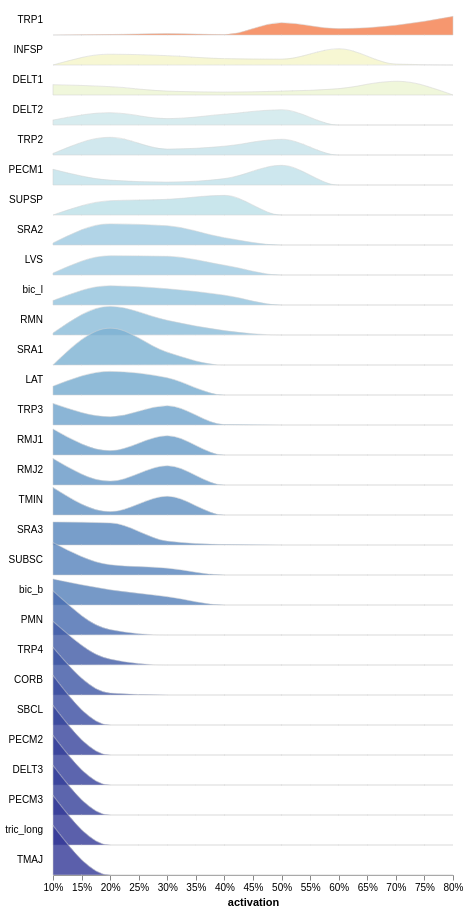

In [12]:
ridge_plot(
    act_melt.groupby(["variable", "index"])["value"].mean().reset_index(),
    value="value",
    groupby="variable",
    sort=act_melt.groupby(["variable"])["value"]
    .mean()
    .sort_values(ascending=False)
    .index.to_list(),
)

## $\sum$activation

In [13]:
sum_act = act_melt.groupby(id_vars)["value"].sum().reset_index()
sum_act.head()

,filename,participant,men,height,mass,n_trial,index,value
0,AimQF12H2_1,aimq,0,2,12,1,0.00,1.695294
1,AimQF12H2_1,aimq,0,2,12,1,0.01,1.409868
2,AimQF12H2_1,aimq,0,2,12,1,0.02,1.289427
3,AimQF12H2_1,aimq,0,2,12,1,0.03,1.375817
4,AimQF12H2_1,aimq,0,2,12,1,0.04,1.737254


In [14]:
y = (
    sum_act.assign(participant=lambda x: x["participant"].astype("category").cat.codes)
    .set_index(id_vars)
    .unstack()
)
y.head()

value                      \
index                                                0.00      0.01      0.02   
filename    participant men height mass n_trial                                 
AimQF12H2_1 0           0   2      12   1        1.695294  1.409868  1.289427   
AimQF12H2_2 0           0   2      12   2        2.019726  1.720067  1.252395   
AimQF6H2_1  0           0   2      6    1        1.693866  1.698144  1.745023   
AimQF6H2_2  0           0   2      6    2        1.714427  1.588956  1.494849   
AimQF6H2_3  0           0   2      6    3        1.396630  1.473158  1.522150   

                                                                               \
index                                                0.03      0.04      0.05   
filename    participant men height mass n_trial                                 
AimQF12H2_1 0           0   2      12   1        1.375817  1.737254  1.798957   
AimQF12H2_2 0           0   2      12   2        1.053381  0.970690  1.160973   
AimQF6H2_1  0           0   2      6    1        3.007067  3.615265  3.720659   
AimQF6H2_2  0           0   2      6    2        1.488349  2.535096  3.311375   
AimQF6H2_3  0           0   2      6    3        1.521850  1.576525  1.583244   

                                                                               \
index                                                0.06      0.07      0.08   
filename    participant men height mass n_trial                                 
AimQF12H2_1 0           0   2      12   1        1.517547  2.436055  4.769140   
AimQF12H2_2 0           0   2      12   2        1.382121  1.292042  2.596440   
AimQF6H2_1  0           0   2      6    1        3.750753  3.732351  3.501193   
AimQF6H2_2  0           0   2      6    2        3.617357  4.031807  4.029766   
AimQF6H2_3  0           0   2      6    3        2.430792  3.873637  3.900408   

                                                           ...            \
index                                                0.09  ...      0.91   
filename    participant men height mass n_trial            ...             
AimQF12H2_1 0           0   2      12   1        5.185554  ...  4.505662   
AimQF12H2_2 0           0   2      12   2        5.654903  ...  6.147710   
AimQF6H2_1  0           0   2      6    1        3.332644  ...  3.646579   
AimQF6H2_2  0           0   2      6    2        3.690903  ...  4.606439   
AimQF6H2_3  0           0   2      6    3        3.384301  ...  4.526428   

                                                                      \
index                                                0.92       0.93   
filename    participant men height mass n_trial                        
AimQF12H2_1 0           0   2      12   1        3.725569   3.646781   
AimQF12H2_2 0           0   2      12   2        6.002689   4.919254   
AimQF6H2_1  0           0   2      6    1        2.990601   2.989856   
AimQF6H2_2  0           0   2      6    2        5.647857  10.776300   
AimQF6H2_3  0           0   2      6    3        4.304496   4.471857   

                                                                       \
index                                                 0.94       0.95   
filename    participant men height mass n_trial                         
AimQF12H2_1 0           0   2      12   1         3.233824   3.125359   
AimQF12H2_2 0           0   2      12   2         4.048877   3.501027   
AimQF6H2_1  0           0   2      6    1         2.517842   2.450383   
AimQF6H2_2  0           0   2      6    2        11.368522  11.561378   
AimQF6H2_3  0           0   2      6    3         4.398621   4.305904   

                                                                       \
index                                                 0.96       0.97   
filename    participant men height mass n_trial                         
AimQF12H2_1 0           0   2      12   1         2.936307   2.358887   
AimQF12H2_2 0           0   2      12   2 

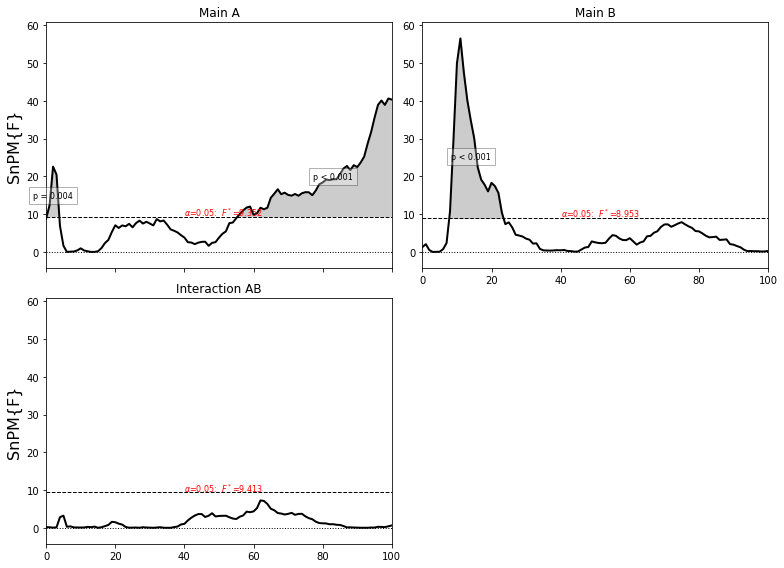

In [15]:
α = 0.05
n_iter = 1000
spm = spm1d.stats.nonparam.anova2(
    y.to_numpy(), A=y.index.get_level_values("men"), B=y.index.get_level_values("mass")
)
spmi = spm.inference(alpha=α, iterations=n_iter)

plt.figure(figsize=(11, 8))
spmi.plot()
plt.tight_layout()

In [16]:
clusters = get_spm_cluster(
    spmi,
    labels={
        "Main A": "main sex",
        "Main B": "main mass",
        "Interaction AB": "interaction sex-mass",
    },
    mult=1 / y.shape[1],
)
clusters

,effect,p,start,end
0,main sex,0.004,0.00148034,0.0377981
1,main sex,0,0.548253,0.990099
2,main mass,0,0.0770674,0.232433


In [17]:
effect = {"main sex": "men", "main mass": "mass"}
clusters = describe_clusters(clusters, sum_act, effect)
clusters

,effect,p,start,end,diff desc,mean diff,cohen d,cohen effect
1,main sex,0.0,0.55,0.99,0 - 1,2.02,0.61,medium
2,main mass,0.0,0.08,0.23,12 - 6,-1.46,-0.73,medium


In [18]:
c = (
    alt.Chart(clusters)
    .mark_rect(opacity=0.3, color="grey")
    .encode(alt.X("start"), alt.X2("end"))
)

In [19]:
base = alt.Chart(sum_act).encode(
    alt.X(
        "index", title="Normalized trial", axis=alt.Axis(format="%", labelFlush=False)
    )
)
mu = base.mark_line().encode(
    alt.Y(
        "mean(value)",
        #         title="Σ force (N)",
        #         axis=alt.Axis(labelFlush=False),
        title="Σ activation (% MVC)",
        axis=alt.Axis(format="%", labelFlush=False),
    )
)
sigma = base.mark_errorband(extent="ci").encode(alt.Y("value", title=None))
men_scale = alt.Scale(scheme="set1")

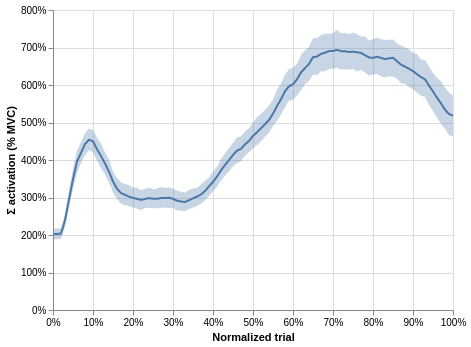

In [20]:
(mu + sigma)  # + c.encode(alt.Color("effect"))

In [21]:
from scipy.signal import find_peaks

t = sum_act.groupby("index")["value"].agg(["mean", "std"])
p, _ = find_peaks(t["mean"], distance=50)
t.iloc[p, :].multiply(100).round()
# t.iloc[p, :].round()

,mean,std
index,,
0.09,454.0,210.0
0.71,694.0,343.0


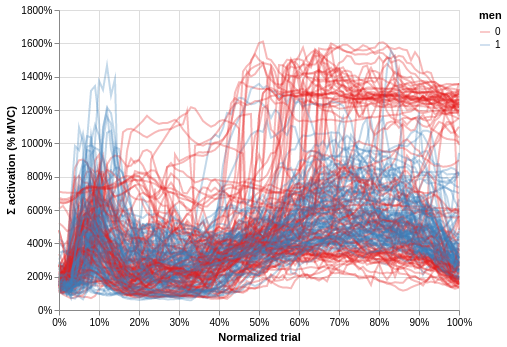

In [22]:
mu.mark_line(opacity=0.3).encode(
    alt.Color("men:N", scale=men_scale), alt.Detail("filename"), alt.Tooltip("filename")
)

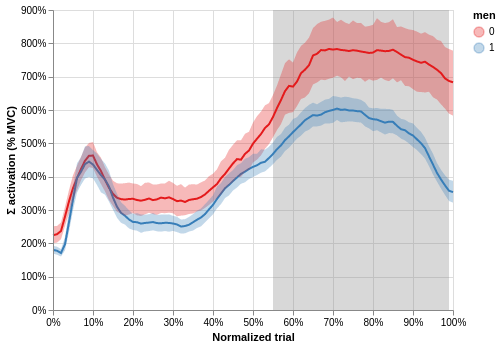

In [25]:
c.transform_filter('datum.effect == "main sex"') + (mu + sigma).encode(
    alt.Color("men:N", scale=men_scale)
)

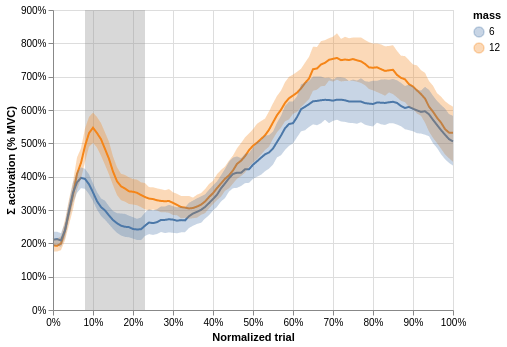

In [26]:
c.transform_filter('datum.effect == "main mass"') + (mu + sigma).encode(
    alt.Color("mass:N")
)

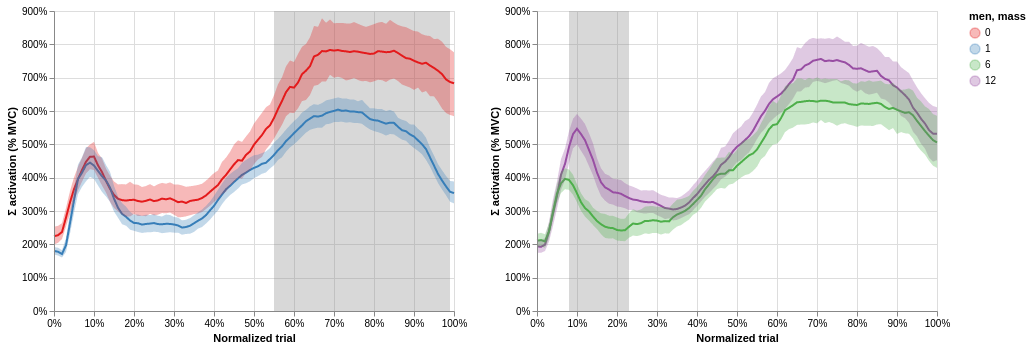

In [27]:
(
    c.transform_filter('datum.effect == "main sex"')
    + (mu + sigma).encode(alt.Color("men:N", scale=men_scale))
    | c.transform_filter('datum.effect == "main mass"')
    + (mu + sigma).encode(alt.Color("mass:N"))
).resolve_scale(x="shared", y="shared")

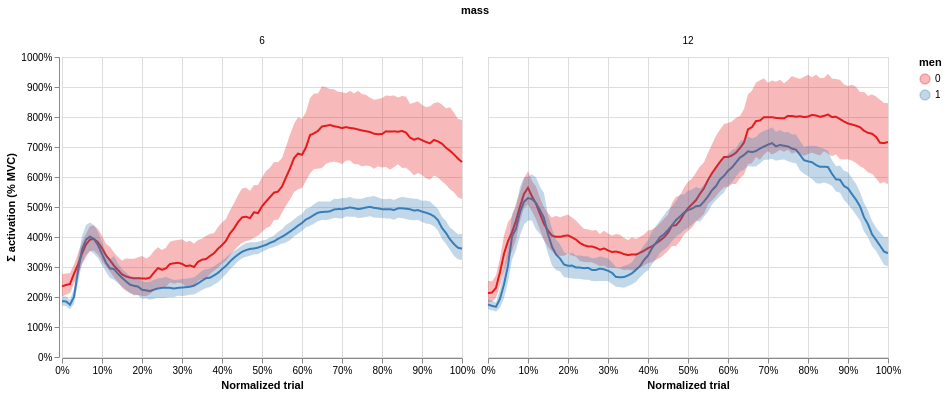

In [28]:
(mu + sigma).encode(alt.Color("men:N", scale=men_scale)).facet(column="mass")

## ECDF

### ECDF on activations

In [29]:
act_melt["ecdf"] = act_melt.groupby("filename")["value"].transform(
    lambda x: x.rank(method="first") / x.shape[0]
)

In [30]:
target_col_shape = 100

y = (
    act_melt.drop(["index", "variable"], axis=1)
    .assign(participant=lambda x: x["participant"].astype("category").cat.codes)
    .set_index([i if i != "index" else "ecdf" for i in id_vars])
    .unstack()
)
y = y.iloc[:, 0 :: int(y.shape[1] / target_col_shape)]
y.head()

value                     \
ecdf                                            0.000341 0.010242  0.020143   
filename    participant men height mass n_trial                               
AimQF12H2_1 0           0   2      12   1           0.01     0.01  0.010000   
AimQF12H2_2 0           0   2      12   2           0.01     0.01  0.010000   
AimQF6H2_1  0           0   2      6    1           0.01     0.01  0.010000   
AimQF6H2_2  0           0   2      6    2           0.01     0.01  0.010000   
AimQF6H2_3  0           0   2      6    3           0.01     0.01  0.010001   

                                                                               \
ecdf                                             0.030044  0.039945  0.049846   
filename    participant men height mass n_trial                                 
AimQF12H2_1 0           0   2      12   1        0.010000  0.010000  0.010000   
AimQF12H2_2 0           0   2      12   2        0.010000  0.010000  0.010000   
AimQF6H2_1  0           0   2      6    1        0.010001  0.010001  0.010001   
AimQF6H2_2  0           0   2      6    2        0.010000  0.010000  0.010000   
AimQF6H2_3  0           0   2      6    3        0.010001  0.010001  0.010001   

                                                                               \
ecdf                                             0.059747  0.069648  0.079549   
filename    participant men height mass n_trial                                 
AimQF12H2_1 0           0   2      12   1        0.010000  0.010000  0.010000   
AimQF12H2_2 0           0   2      12   2        0.010000  0.010000  0.010000   
AimQF6H2_1  0           0   2      6    1        0.010001  0.010002  0.010002   
AimQF6H2_2  0           0   2      6    2        0.010000  0.010000  0.010000   
AimQF6H2_3  0           0   2      6    3        0.010001  0.010002  0.010002   

                                                           ...            \
ecdf                                             0.089450  ...  0.901332   
filename    participant men height mass n_trial            ...             
AimQF12H2_1 0           0   2      12   1        0.010000  ...  0.431307   
AimQF12H2_2 0           0   2      12   2        0.010000  ...  0.407583   
AimQF6H2_1  0           0   2      6    1        0.010002  ...  0.365024   
AimQF6H2_2  0           0   2      6    2        0.010001  ...  0.658044   
AimQF6H2_3  0           0   2      6    3        0.010002  ...  0.399207   

                                                                               \
ecdf                                             0.911233  0.921133  0.931034   
filename    participant men height mass n_trial                                 
AimQF12H2_1 0           0   2      12   1        0.462041  0.490679  0.534177   
AimQF12H2_2 0           0   2      12   2        0.449079  0.484957  0.535252   
AimQF6H2_1  0           0   2      6    1        0.390100  0.418324  0.443469   
AimQF6H2_2  0           0   2      6    2        0.717515  0.806312  0.924321   
AimQF6H2_3  0           0   2      6    3        0.429243  0.448291  0.469097   

                                                                               \
ecdf                                             0.940935  0.950836  0.960737   
filename    participant men height mass n_trial                                 
AimQF12H2_1 0           0   2      12   1        0.584367  0.640617  0.720695   
AimQF12H2_2 0           0   2      12   2        0.582847  0.633730  0.698899   
AimQF6H2_1  0           0   2      6    1        0.462945  0.494422  0.524442   
AimQF6H2_2  0           0   2      6    2        0.999995  1.000000  1.000000   
AimQF6H2_3  0           0   2      6    3        0.490421  0.523959  0.544304   

                                                                               
ecdf                                             0.970638  0.980539  0.990440  
filename    participant men height mass n_trial      

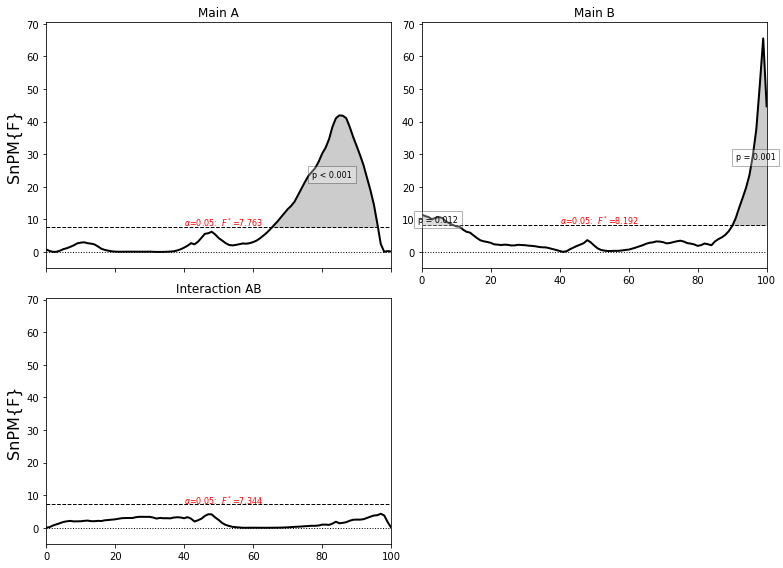

In [31]:
α = 0.05
n_iter = 1000
spm = spm1d.stats.nonparam.anova2(
    y.to_numpy(), A=y.index.get_level_values("men"), B=y.index.get_level_values("mass")
)
spmi = spm.inference(alpha=α, iterations=n_iter)

plt.figure(figsize=(11, 8))
spmi.plot()
plt.tight_layout()

In [32]:
clusters = get_spm_cluster(
    spmi,
    labels={
        "Main A": "main sex",
        "Main B": "main mass",
        "Interaction AB": "interaction sex-mass",
    },
    mult=1 / y.shape[1],
)
clusters

,effect,p,start,end
0,main sex,0,0.650096,0.951942
1,main mass,0.0116667,0,0.0911254
2,main mass,0.000666667,0.892197,0.990099


In [33]:
ecdf = y.stack().reset_index()
clusters = describe_clusters(clusters, ecdf.rename(columns=dict(ecdf="index")), effect)
clusters

,effect,p,start,end,diff desc,mean diff,cohen d,cohen effect
0,main sex,0.000000,0.65,0.95,0 - 1,0.13,0.51,medium
1,main mass,0.011667,0.00,0.09,12 - 6,0.00,0.36,small
2,main mass,0.000667,0.89,0.99,12 - 6,-0.13,-0.55,medium


In [34]:
c = (
    alt.Chart(clusters)
    .mark_rect(opacity=0.3, color="grey")
    .encode(alt.X("start"), alt.X2("end"))
)

In [35]:
base = alt.Chart(ecdf).encode(alt.X("ecdf", axis=alt.Axis(format="%"), title="ECDF"))
mu = base.mark_line().encode(
    alt.Y(
        "mean(value)",
        title="Activation (% MVC)",
        axis=alt.Axis(format="%", labelFlush=False)
        #         title="Force (N)",
        #         axis=alt.Axis(labelFlush=False),
    )
)
sigma = base.mark_errorband(extent="ci").encode(alt.Y("value", title=None))

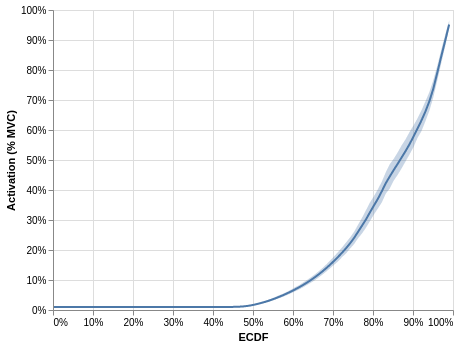

In [36]:
(mu + sigma)  # + c.encode(alt.Color("effect"))

In [37]:
print(ecdf.query("ecdf < 0.5")["value"].agg(["mean", "std"]).multiply(100))
print(ecdf.query("ecdf > 0.5")["value"].agg(["mean", "std"]).multiply(100))

# print(ecdf.query("ecdf < 0.5")["value"].agg(["mean", "std"]))
# print(ecdf.query("ecdf > 0.5")["value"].agg(["mean", "std"]))

mean    1.026150
std     0.210991
Name: value, dtype: float64
mean    31.472516
std     31.294299
Name: value, dtype: float64


In [38]:
value = [0.6, 0.8, 1]
# index = (df['values'] - value).abs().idxmin()
x = ecdf.groupby("ecdf")["value"].agg(["mean", "std"]).reset_index()

[x.iloc[x["ecdf"].sub(i).abs().idxmin()].multiply(100).round() for i in value]
# [x.iloc[x["ecdf"].sub(i).abs().idxmin()].round() for i in value]

[ecdf    60.0
 mean     7.0
 std      5.0
 Name: 61, dtype: float64, ecdf    80.0
 mean    35.0
 std     23.0
 Name: 81, dtype: float64, ecdf    99.0
 mean    95.0
 std     10.0
 Name: 100, dtype: float64]

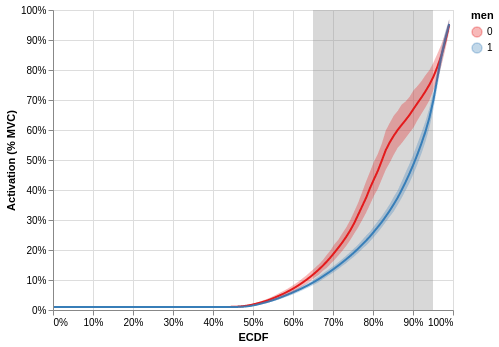

In [39]:
c.transform_filter('datum.effect == "main sex"') + (mu + sigma).encode(
    alt.Color("men:N", scale=men_scale)
)

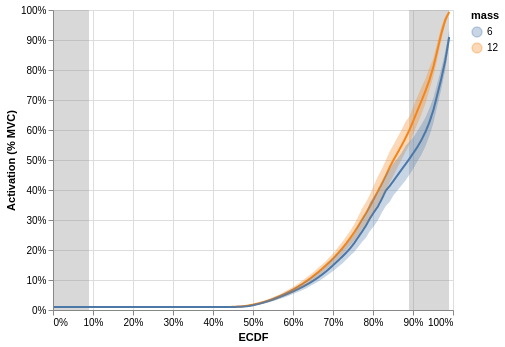

In [40]:
c.transform_filter('datum.effect == "main mass"') + (mu + sigma).encode(
    alt.Color("mass:N")
)

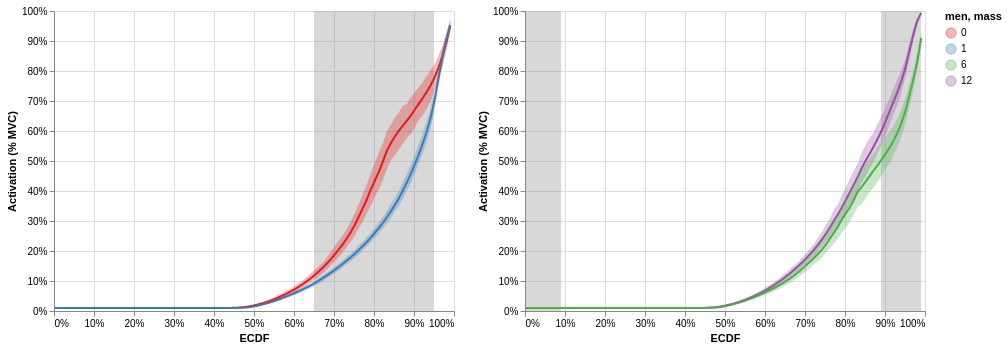

In [41]:
(
    c.transform_filter('datum.effect == "main sex"')
    + (mu + sigma).encode(alt.Color("men:N", scale=men_scale))
    | c.transform_filter('datum.effect == "main mass"')
    + (mu + sigma).encode(alt.Color("mass:N"))
).resolve_scale(x="shared", y="shared")

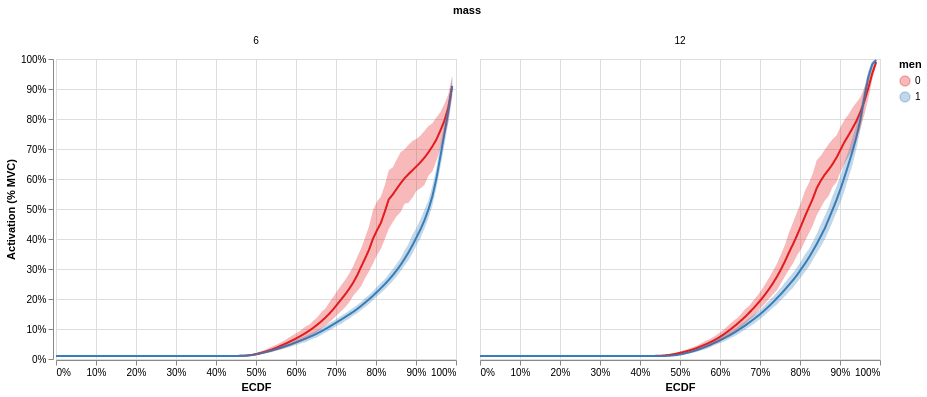

In [42]:
(mu + sigma).encode(alt.Color("men:N", scale=men_scale)).facet(column="mass")

## $\sum\sum\text{activations}$

In [42]:
sum_sum_act = (
    sum_act.groupby([i for i in id_vars if i != "index"])["value"].sum().reset_index()
)
sum_sum_act.head()

,filename,participant,men,height,mass,n_trial,value
0,AimQF12H2_1,aimq,0,2,12,1,367.091902
1,AimQF12H2_2,aimq,0,2,12,2,341.375770
2,AimQF6H2_1,aimq,0,2,6,1,351.786640
3,AimQF6H2_2,aimq,0,2,6,2,548.178460
4,AleBH12H2_1,aleb,1,2,12,1,512.630851


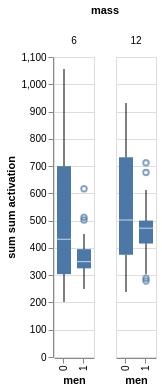

In [43]:
alt.Chart().mark_boxplot().encode(
    alt.X("men:N"), alt.Y("value", title="sum sum activation")
).facet(data=sum_sum_act, column=alt.Column("mass"))

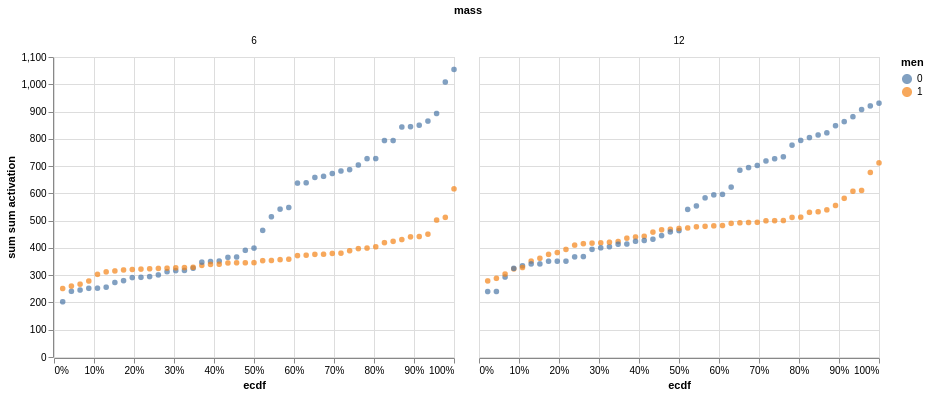

In [44]:
alt.Chart(
    sum_sum_act.assign(
        ecdf=lambda x: x.groupby(["men", "mass"])["value"].transform(
            lambda x: x.rank(method="first") / x.shape[0]
        )
    )
).mark_circle().encode(
    alt.X("ecdf", axis=alt.Axis(format="%")),
    alt.Y("value", title="sum sum activation"),
    alt.Color("men:N"),
    alt.Column("mass"),
)

<!--NAVIGATION-->
< [Analyses](02.00-men-women.ipynb) | [Contents](Index.ipynb) | [Joint reactions](02.02-joint-reactions.ipynb) >